In [ ]:
import os
import numpy as np
import tensorflow.compat.v1 as tf
from tensorflow.python.client import device_lib
 
import matplotlib.pyplot as plt
import seaborn as sns
import keras
 
import warnings
warnings.filterwarnings('ignore')
 
print("All Imported!")

All Imported!


In [ ]:
print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.4.1


In [ ]:
# disabeling eager execution
tf.disable_eager_execution()

In [ ]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 545111575986708447, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14674281152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16742812141062460082
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [ ]:
# mounting google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir("/content/drive/MyDrive/pix2pix")

In [ ]:
# loading the data into numpy arrays
source_image_path = "data/preprocessed_data/source.npy"
target_image_path = "data/preprocessed_data/target.npy"

source = np.load(source_image_path)
target = np.load(target_image_path)

In [ ]:
# all total we have 5000 images per 
print("Source Tensor shape:", source.shape)
print("Target Tensor shape:", target.shape)

Source Tensor shape: (1096, 256, 256, 3)
Target Tensor shape: (1096, 256, 256, 3)


In [ ]:
# Hyperparameters
image_height = 256
image_width = 256
image_channels = 3

GEN_LEARNING_RATE = 0.0002
DISC_LEARNING_RATE = 0.0002
beta_1 = 0.5
beta_2 = 0.999
BATCH_SIZE = 1

epochs = 180
Lambda = 100

In [ ]:
# all the pixel values will range between [-1, +1]
def preprocess_images(image):
    return (image / 127.5) - 1.0

In [ ]:
def source_data_generator(data, batch_size = BATCH_SIZE):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function= preprocess_images)
    datagen.fit(data)
    gen = datagen.flow(data, batch_size= batch_size, shuffle=False)
    while True:
            batch = gen.next()
            yield batch

def target_data_generator(data, batch_size = BATCH_SIZE):
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function= preprocess_images)
    datagen.fit(data)
    gen = datagen.flow(data, batch_size= batch_size, shuffle=False)
    while True:
            batch = gen.next()
            yield batch

In [ ]:
def discriminator(input_img, target_img, reuse = None):
    """
    The discriminator is a PatchGAN
    """
    with tf.variable_scope("discriminator_model", reuse= reuse):

        concatenated_image = tf.concat([input_img, target_img], axis = 3)
        weight_init =  tf.random_normal_initializer(mean=0.0, stddev=0.02)
        paddings = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])

        # FIRST BLOCK
        x = tf.layers.conv2d(inputs = concatenated_image,
                            strides = 2,
                            kernel_size = 4,
                            filters = 64,
                            padding = "SAME",
                            kernel_initializer = weight_init,
                            )
        x = tf.nn.leaky_relu(x,  alpha = 0.2) # OUTPUT_SHAPE: (None, 128, 128, 64)

        # SECOND BLOCK
        x = tf.layers.conv2d(x,
                            filters = 128,
                            padding = "SAME",
                            kernel_size = 4,
                            strides =2,
                            kernel_initializer = weight_init,
                            use_bias = False,
                            )
        x = tf.layers.batch_normalization(x, training = True, axis = -1)
        x = tf.nn.leaky_relu(x, alpha = 0.2) # OUTPUT_SHAPE: (None, 64. 64, 128)

        # THIRD BLOCK
        x = tf.layers.conv2d(x,
                            filters = 256,
                            padding = "SAME",
                            kernel_size = 4,
                            strides =2,
                            kernel_initializer = weight_init,
                            use_bias = False,
                            )
        x = tf.layers.batch_normalization(x, training = True, axis = -1)
        x = tf.nn.leaky_relu(x, alpha = 0.2) # OUTPUT_SHAPE: (None, 32, 32, 256)

        # ZERO PADDING 
        x = tf.pad(tensor = x, paddings = paddings, mode='CONSTANT', constant_values=0) # OUTPUT_SHAPE: (None, 34, 34, 256)

        # FOURTH BLOCK
        x = tf.layers.conv2d(x,
                            filters = 512,
                            padding = "VALID",
                            kernel_size = 4,
                            strides =1,
                            kernel_initializer = weight_init,
                            use_bias = False,
                            )
        x = tf.layers.batch_normalization(x, training = True, axis = -1)
        x = tf.nn.leaky_relu(x, alpha = 0.2) # OUTPUT_SHAPE: (None, 31, 31, 512)

        # ZERO PADDING
        x = tf.pad(tensor = x, paddings = paddings, mode='CONSTANT', constant_values=0) # OUPUT_SHAPE: (None, 33, 33, 512)

        # FINAL BLOCK
        patch = tf.layers.conv2d(x,
                        filters = 1,
                        padding = "VALID",
                        kernel_size = 4,
                        strides =1,
                        kernel_initializer = weight_init,
                        use_bias = False,
                        ) # OUTPUT_SHAPE: (None, 30, 30, 1)
        return patch

In [ ]:
# Helper functions 
def upsample(input_tensor, num_filters, kernel_size, apply_dropout= False):
    # init. weights from a random normal distribution
    weight_init = tf.random_normal_initializer(0., 0.02)

    # Transposed convolution -> batch_norm -> relu
    result = tf.layers.conv2d_transpose(inputs= input_tensor,
                                        filters = num_filters,
                                        strides = 2,
                                        kernel_size = kernel_size,
                                        use_bias = False,
                                        kernel_initializer = weight_init,
                                        padding = "SAME",
                                        
                                        )
    result = tf.layers.batch_normalization(result, training = True, axis = -1)
    if apply_dropout:
        result = tf.nn.dropout(result, keep_prob=0.5)

    result = tf.nn.relu(result)

    return result


def downsample(input_tensor, num_filters, kernel_size, apply_batchnorm):
    # init. from a random normal distribution
    weight_init = tf.random_normal_initializer(0., 0.02)

    # Conv2D -> BatchNorm -> Leaky Relu
    result = tf.layers.conv2d(input_tensor,
                        filters = num_filters,
                        padding = "SAME",
                        kernel_size = kernel_size,
                        strides =2,
                        kernel_initializer = weight_init,
                        use_bias = False,
                        )
    if apply_batchnorm:
        result = tf.layers.batch_normalization(result, training = True, axis = -1)

    result = tf.nn.leaky_relu(result, alpha = 0.2)
    return result

In [ ]:
def generator(source_img, reuse = None):
    with tf.variable_scope("generator_model", reuse= reuse):

        # Downsampling block
        down_1 = downsample(input_tensor= source_img,
                    num_filters = 64,
                    kernel_size= 4,
                    apply_batchnorm= True)
        
        down_2 = downsample(input_tensor= down_1,
                    num_filters = 128,
                    kernel_size= 4,
                    apply_batchnorm= True)
        
        down_3 = downsample(input_tensor= down_2,
                    num_filters = 256,
                    kernel_size= 4,
                    apply_batchnorm= True)
        
        down_4 = downsample(input_tensor= down_3,
                    num_filters = 512,
                    kernel_size= 4,
                    apply_batchnorm= True)
        
        down_5 = downsample(input_tensor= down_4,
                    num_filters = 512,
                    kernel_size= 4,
                    apply_batchnorm= True)
        
        down_6 = downsample(input_tensor= down_5,
                    num_filters = 512,
                    kernel_size= 4,
                    apply_batchnorm= True)
        
        down_7 = downsample(input_tensor= down_6,
                    num_filters = 512,
                    kernel_size= 4,
                    apply_batchnorm= True)
        
        down_8 = downsample(input_tensor= down_7,
                    num_filters = 512,
                    kernel_size= 4,
                    apply_batchnorm= True)
        
        # Upsampling Block
        up_1 = upsample(input_tensor = down_8,
                        num_filters = 512,
                        kernel_size = 4,
                        apply_dropout = True)
        up_1 = tf.concat([up_1, down_7], axis = 3)

        up_2 =  upsample(input_tensor = up_1,
                        num_filters = 512,
                        kernel_size = 4,
                        apply_dropout = True)
        up_2 = tf.concat([up_2, down_6], axis = 3)

        up_3 =  upsample(input_tensor = up_2,
                        num_filters = 512,
                        kernel_size = 4,
                        apply_dropout = True)
        up_3 = tf.concat([up_3, down_5], axis = 3)

        up_4 =  upsample(input_tensor = up_3,
                        num_filters = 512,
                        kernel_size = 4)
        up_4 = tf.concat([up_4, down_4], axis = 3)

        up_5 =  upsample(input_tensor = up_4,
                        num_filters = 256,
                        kernel_size = 4)
        up_5 = tf.concat([up_5, down_3], axis = 3)


        up_6 =  upsample(input_tensor = up_5,
                        num_filters = 128,
                        kernel_size = 4)
        up_6 = tf.concat([up_6, down_2], axis = 3)

        up_7 =  upsample(input_tensor = up_6,
                        num_filters = 64,
                        kernel_size = 4)
        up_7 = tf.concat([up_7, down_1], axis = 3)


        # Last output image
        random_normal_init = tf.random_normal_initializer(0., 0.02)
        output_image = tf.layers.conv2d_transpose(inputs= up_7,
                                            filters = 3,
                                            strides = 2,
                                            kernel_size = 4,
                                            padding = "SAME",
                                            kernel_initializer = random_normal_init,
                                            activation = "tanh")
        
        return output_image

In [ ]:
def generator_loss(LAMBDA, gen_output, disc_output):
    lbl = tf.ones_like(disc_output)
    BCE_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = disc_output,
                                                                      labels = lbl))
    l1_loss = tf.reduce_mean(tf.abs(Y - gen_output))
    gen_loss = BCE_loss + (LAMBDA * l1_loss)
    return  gen_loss, l1_loss, BCE_loss

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_lables = tf.ones_like(disc_real_output)
    real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = disc_real_output,
                                                                      labels = real_lables))
    fake_lables = tf.zeros_like(disc_generated_output)
    generated_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = disc_generated_output,
                                                                      labels = fake_lables))
    loss = generated_loss + real_loss
    return loss

In [ ]:
tf.reset_default_graph()

# Placeholders 

# Target image
Y = tf.placeholder(tf.float32, shape = [None, image_height, image_width, image_channels]) 

# Source image
X = tf.placeholder(tf.float32, shape = [None, image_height, image_width, image_channels])


with tf.name_scope("Generator") as scope:
    gen_output = generator(source_img = X)

with tf.name_scope("Discriminator") as scope:
    disc_real_output = discriminator(input_img = X,
                                     target_img = Y)
    
    disc_gen_output = discriminator(input_img = X,
                                    target_img = gen_output,
                                    reuse = True)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
# discriminator loss
with tf.name_scope("discriminator_loss") as scope:
    disc_loss = discriminator_loss(disc_real_output, disc_gen_output)

In [ ]:
# generator loss
with tf.name_scope("generator_loss") as scope:
    gen_gan_loss, L1_gan_loss, gen_BCE_loss = generator_loss(LAMBDA = Lambda,
                        gen_output = gen_output,
                        disc_output = disc_gen_output)

In [ ]:
# Build Optimizers
with tf.name_scope("Generator_optimizer") as scope:
  optimizer_gen = tf.train.AdamOptimizer(learning_rate=GEN_LEARNING_RATE, beta1= beta_1, beta2 = beta_2)

with tf.name_scope("Discriminator_optimizer") as scope:
  optimizer_disc = tf.train.AdamOptimizer(learning_rate=DISC_LEARNING_RATE, beta1 = beta_1, beta2 = beta_2)

In [ ]:
# vars of generator and discriminator
vars = tf.trainable_variables()
gen_params = [var for var in vars if "generator_model" in var.name]
disc_params = [var for var in vars if "discriminator_model" in var.name]

# optimizers
train_gen = optimizer_gen.minimize(gen_gan_loss, var_list=gen_params)
train_disc = optimizer_disc.minimize(disc_loss, var_list=disc_params)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


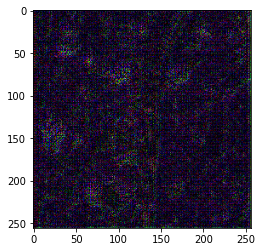

In [ ]:
# Ourput of the generator when given a google map image
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    image = np.expand_dims(source[0,...], axis = 0)
    gen_image = sess.run(gen_output,
                         feed_dict = {X : image})
    plt.imshow(gen_image.reshape(256, 256, 3))

In [ ]:
# for plotting source image, generated image and target image
def plot(src_image, gen_image, trg_image):
    f, axarr = plt.subplots(1,3,  figsize=(14, 14))
 
    axarr[0].imshow(src_image);
    axarr[0].set_xlabel('Source_image')
 
    axarr[1].imshow(gen_image);
    axarr[1].set_xlabel('Generated_image')
 
 
    axarr[2].imshow(trg_image);
    axarr[2].set_xlabel('Target_image')
 
    plt.show()

In [ ]:
# generators that will yield tensor of shape : (Batch_size, 256, 256, 3)
source_datagen = source_data_generator(data = source, batch_size = BATCH_SIZE)
target_datagen = target_data_generator(data = target, batch_size = BATCH_SIZE)

In [ ]:
steps_per_epoch = source.shape[0] // BATCH_SIZE

init = tf.global_variables_initializer()

saver = tf.train.Saver()
saver_path = "/content/drive/MyDrive/pix2pix/models/model"

In [ ]:
# training loop
with tf.Session() as sess:
    sess.run(init)
    print("Training started...")
    for epc in range(1, epochs+1):
        step = 0
        G, D, gen_l1_loss = [], [], []
        for source_batch, target_batch in zip(source_datagen, target_datagen):
            _ , _, gl, l1, dl = sess.run([train_gen, train_disc, gen_BCE_loss, L1_gan_loss, disc_loss],
                                     feed_dict = {
                                         X: source_batch,
                                         Y : target_batch
                                     })
            step += 1
            if step == steps_per_epoch:
                break
            G.append(gl)
            D.append(dl)
            gen_l1_loss.append(l1)
        G_L, D_L, L1_loss = np.mean(G), np.mean(D), np.mean(gen_l1_loss)
        print(f"Epoch: {epc} | Generator Loss: {G_L}, L1 loss: {L1_loss}, Discriminator Loss: {D_L}")
 
        # For visualisation
        index = np.random.randint(low = 0, high=source.shape[0])
        source_map, target_map = source[index, ...], target[index, ...]
        generated_satelite_map = sess.run(gen_output, feed_dict = {
            X : source_map.reshape(1, image_height, image_width, image_channels)
        }).reshape(image_height, image_width, image_channels)
    
        plot(src_image = source_map,
             gen_image = generated_satelite_map,
             trg_image = target_map)
        print("\n")
        
    # saving the model
    saver.save(sess, saver_path)

In [ ]:
plt.style.use('seaborn-whitegrid');
plt.figure(figsize = (9, 6));
 
plt.plot(gen_l1_loss, color = "orange", linewidth = 3);
plt.ylabel("Generator L1 loss");
plt.xlabel("Epochs");

In [ ]:
# plotting the generator loss and discriminator loss
plt.figure(figsize = (12, 8))
 
plt.plot(G, label = "generator_loss");
plt.plot(D, label = "discriminator_loss");
plt.legend();
plt.show();